In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as lines
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm(vmin=1,vmax=15)}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kaon_pn_4GeV_Jul13_nobias_ntuple.root")

In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x
    
    
def track_smear(kinetic_energy, theta):
    # assume flat uncertainty on the energy (I think that is 6%)
    c_eres = random.gauss(1.,0.06); # flat 10% uncertainty for now
    # assume some uncertainty on the angle (I think that is 2%)
    c_hres = random.gauss(0.,0.02); # 1 degrees
    return (c_eres*kinetic_energy, abs(c_hres+theta))

def test_smear(pz):
    c_eres_array = []
    for part in pz:
        for element in part:
            if element <= 50:
                c_eres = random.gauss(1,0.0404);
            elif element <= 100: 
                c_eres = random.gauss(1,0.0410);
            elif element <= 250: 
                c_eres = random.gauss(1,0.0415);
            elif element <= 500: 
                c_eres = random.gauss(1,0.0420);
            elif element <= 1000: 
                c_eres = random.gauss(1,0.0435);
            elif element <= 2000:  
                c_eres = random.gauss(1,0.0477);
            elif element <= 3000:  
                c_eres = random.gauss(1,0.0523);
            elif element <= 4000:  
                c_eres = random.gauss(1,0.0573);            
            else:    
                c_eres = random.gauss(1,0.06);
            c_eres_array=np.append(c_eres_array, [c_eres])
    return (c_eres_array)    

In [4]:
hists = {}
hists["hist_kaon_e"] = hist.Hist("Sim Pions",  
                                hist.Bin("k", r"$K$ Kinetic Energy [MeV]", 40, 0, 3500),
                                hist.Bin("e", r"Electron Energy [MeV]", 40, 0, 1500),
                            )
hists["hist_kaon_e_40"] = hist.Hist("Sim Pions",      
                                hist.Bin("k", r"$K$ Kinetic Energy [MeV]", 40, 0, 3500),
                                hist.Bin("e", r"Electron Energy [MeV]", 40, 0, 1500),
                            )

In [5]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    
    sim_particle = ldmx_events['Sim_Kaon']
    sim_particle_dau1 = ldmx_events['Sim_Kaon_dau1']
    sim_particle_dau2 = ldmx_events['Sim_Kaon_dau2']
    
    particle_vector = get_vector(sim_particle)
    dau1 = get_vector(sim_particle_dau1)
    dau2 = get_vector(sim_particle_dau2)

    theta_mask1 = dau1.theta*180/math.pi <=40
    theta_mask2 = dau2.theta*180/math.pi <=40
    
    kaon_mass = 493.677
    
    hists["hist_kaon_e"].fill(
                                 k = flat(flat(sim_particle.e) - kaon_mass),
                                 e = flat(sim_particle.electrone),
                                )
    hists["hist_kaon_e"].fill(
                                 k = flat(flat(sim_particle[theta_mask1&theta_mask2].e) - kaon_mass),
                                 e = flat(sim_particle[theta_mask1&theta_mask2].electrone),
                                )

    
    #hists["sim_kaone_hist_thetacut"].fill(
    #                             k = flat(pisum_track_smeared[theta_mask1].t) - kaon_mass,
    #                             e = flat(sim_kaon_dau2[kshort_mask][theta_mask2].electrone),
    #                            )


In [6]:
nchunk = 0
for chunk in ldmx_dict:
    nchunk += 1
    ProcessChunk(chunk, hists)
    print('process', nchunk)

process 1


<Hist (k,e) instance at 0x13122d400>


KeyError: ()

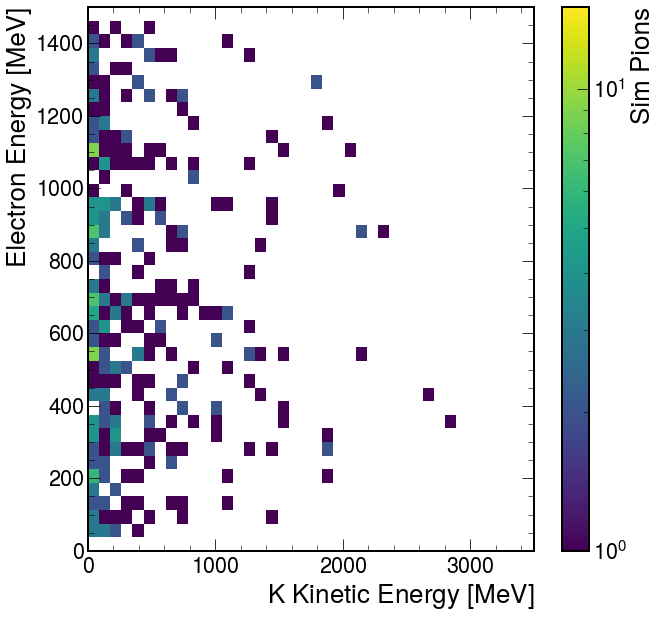

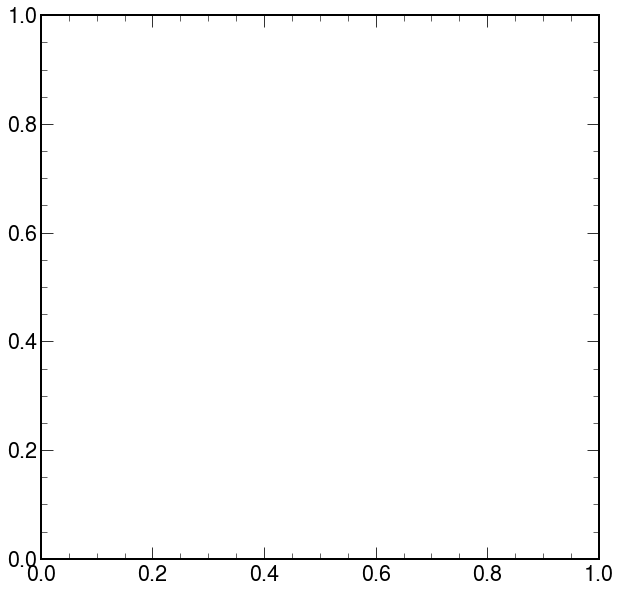

In [9]:
print(hists["hist_kaon_e"])

fig, ax = plt.subplots()
hist.plot2d(hists["hist_kaon_e"], xaxis='k', ax=ax, patch_opts=POPTS);
#ax.text(2900, 1400,r'All $\theta$')
fig, ax = plt.subplots()
hist.plot2d(hists["hist_kaon_e_40"], xaxis='k', ax=ax, patch_opts=POPTS);

In [8]:
print(hists["Target_kaone_hist"])

fig, ax = plt.subplots()
hist.plot2d(hists["Target_kaone_hist"].integrate('Ktype', ['Kshort']), xaxis='k', ax=ax, patch_opts=POPTS);
x = np.arange(0, 3250, 1)
ytest = (-1.25*(x)+2660)
#ax.plot(x, ytest, '-')


fig, ax = plt.subplots()
ax.set_xlim(0, 3500)
ax.set_ylim(0, 1400)
y0 = -x
y1 = (-4.35*(x)+2150)
y2 = (-3.35*(x)+2150)
y3 = (-2.50*(x)+2150)
y4 = (-1.75*(x)+3350)
y5 = (-0.97*(x)+3350)
y6 = (3350)
ax.plot(x, y5, '-')

ax.fill_between(x, y0, y1, where=(y1 > y0), facecolor='red', alpha=0.5)
ax.fill_between(x, y1, y2, where=(y2 > y1), facecolor='orange', alpha=0.5)
ax.fill_between(x, y2, y3, where=(y3 > y2), facecolor='yellow', alpha=0.5)
ax.fill_between(x, y3, y4, where=(y4 > y3), facecolor='green', alpha=0.5)
ax.fill_between(x, y4, y5, where=(y5 > y4), facecolor='blue', alpha=0.5)
#ax.fill_between(x, y5, y6, where=(y6 > y5), facecolor='yellow', alpha=0.5)
ax.set_ylabel('Electron Energy (MeV)', loc='top')
ax.set_xlabel('Kaon Kinetic Energy (MeV)', loc='right')
ax.text(50, 200, '20%')
ax.text(400, 100, '20%')
ax.text(500, 300, '20%')
ax.text(1200, 200, '20%')
ax.text(2500, 200, '20%')




KeyError: 'Target_kaone_hist'